#### PyTorch

In [1]:
#import
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
# Transformer Parameters
# Padding Should be Zero index
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5
tgt_len = 5

d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

In [2]:
#method
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    # print(seq_q)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

In [3]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return nn.LayerNorm(d_model)(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 5).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, 5):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

Epoch: 0001 cost = 1.792950
Epoch: 0002 cost = 0.246735
Epoch: 0003 cost = 0.203825
Epoch: 0004 cost = 0.074053
Epoch: 0005 cost = 0.015260
Epoch: 0006 cost = 0.405751
Epoch: 0007 cost = 0.004115
Epoch: 0008 cost = 0.185675
Epoch: 0009 cost = 0.008908
Epoch: 0010 cost = 0.009973
Epoch: 0011 cost = 1.606894
Epoch: 0012 cost = 0.134236
Epoch: 0013 cost = 0.073190
Epoch: 0014 cost = 0.642452
Epoch: 0015 cost = 0.379640
Epoch: 0016 cost = 0.319108
Epoch: 0017 cost = 0.001650
Epoch: 0018 cost = 0.032410
Epoch: 0019 cost = 0.207289
Epoch: 0020 cost = 0.020015
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


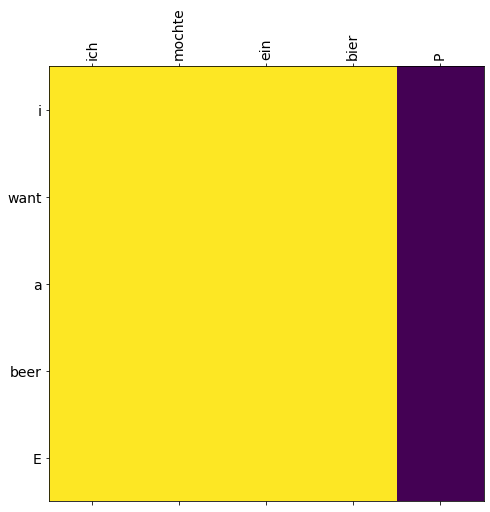

first head of last state dec_self_attns


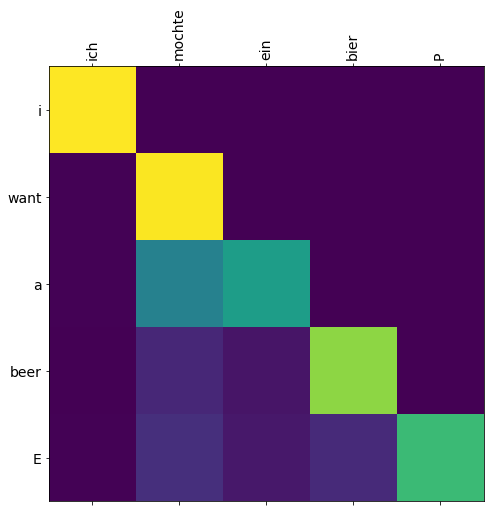

first head of last state dec_enc_attns


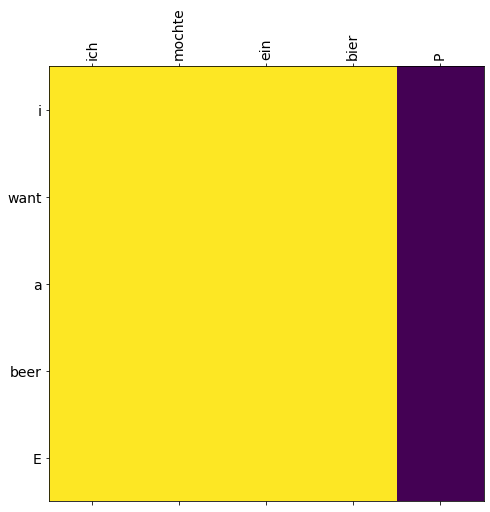

In [4]:
model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

# Test
greedy_dec_input = greedy_decoder(model, enc_inputs, start_symbol=tgt_vocab["S"])
predict, _, _, _ = model(enc_inputs, greedy_dec_input)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)

#### Another Example

In [5]:
#import
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\wheel\pep425tags.py:83: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):
C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\wheel\pep425tags.py:88: RuntimeWarning: Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
  sys.version_info < (3, 8))) \


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# Transformer Parameters
# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5
tgt_len = 5

d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

In [7]:
#method
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return nn.LayerNorm(d_model)(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 0001 cost = 1.868894
Epoch: 0002 cost = 0.158738
Epoch: 0003 cost = 0.120541
Epoch: 0004 cost = 0.012763
Epoch: 0005 cost = 0.012278
Epoch: 0006 cost = 0.010707
Epoch: 0007 cost = 0.015362
Epoch: 0008 cost = 0.001771
Epoch: 0009 cost = 0.002834
Epoch: 0010 cost = 0.001696
Epoch: 0011 cost = 0.028573
Epoch: 0012 cost = 0.000336
Epoch: 0013 cost = 0.000258
Epoch: 0014 cost = 0.015879
Epoch: 0015 cost = 0.001125
Epoch: 0016 cost = 0.001095
Epoch: 0017 cost = 0.002252
Epoch: 0018 cost = 0.000766
Epoch: 0019 cost = 0.001019
Epoch: 0020 cost = 0.001499
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


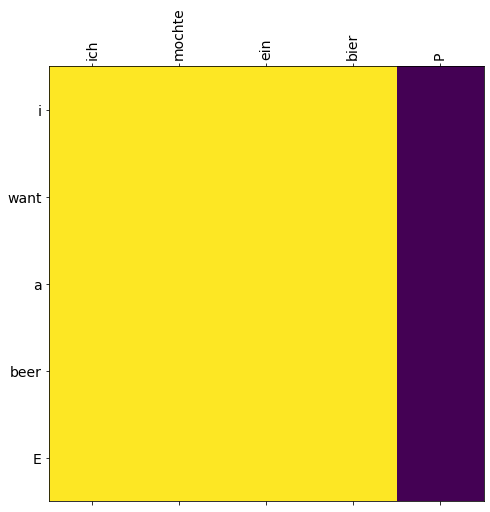

first head of last state dec_self_attns


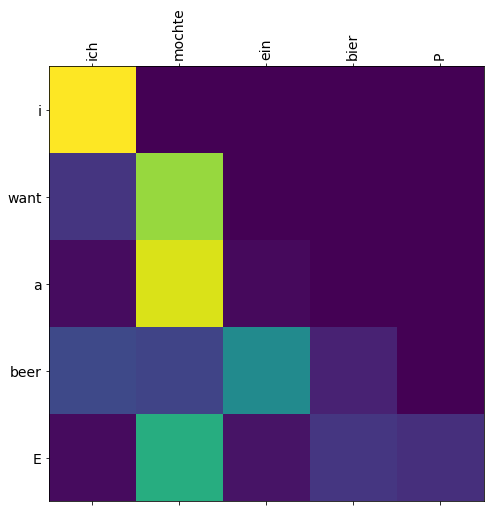

first head of last state dec_enc_attns


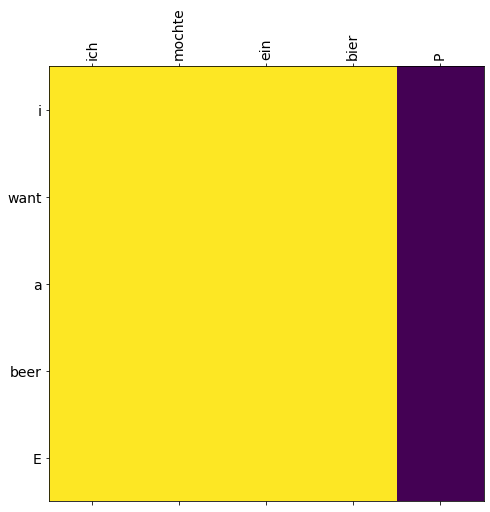

In [8]:
def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

for epoch in range(20):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)

#### Annotated Transformer

In [9]:
#import
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

#### Model Architecture

In [10]:
#Define Encoder
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [11]:
#Generator
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

#### Encoder and Decoder Stacks

In [12]:
#clone
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [13]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [14]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [15]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [16]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

#### Decoder

In [17]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [18]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [19]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

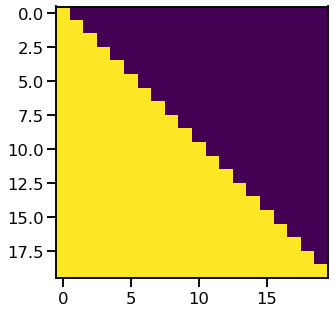

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

#### Attention

In [21]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

#### Position-wise Feed-Forward Networks

In [23]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

#### Embeddings and Softmax

In [24]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

#### Positional Encoding

In [25]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

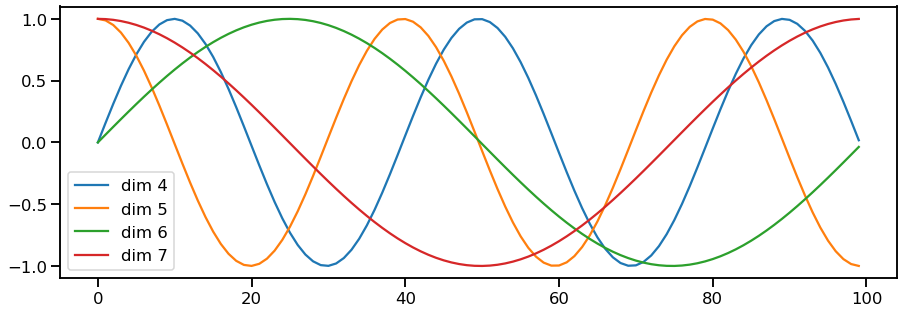

In [26]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

#### Full Model

In [27]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

#### Training (Batches and Masking)

In [28]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

#### Training Loop

In [29]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

#### Training Data and Batching

In [30]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

#### Optimizer

In [31]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

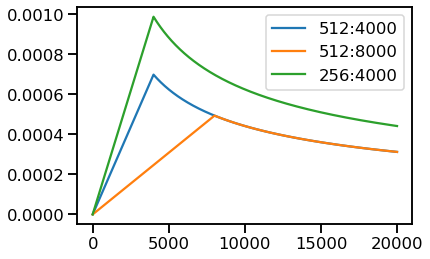

In [32]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

#### Regularization

In [33]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


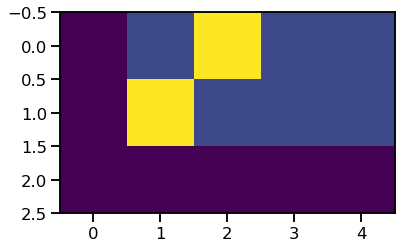

In [34]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

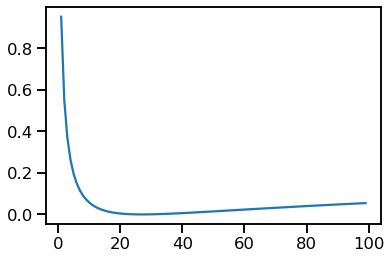

In [35]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data.item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

#### Real World Example

In [36]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy.prefer_gpu()
    spacy_de = spacy.load('en_core_web_sm')
    spacy_en = spacy.load("en_core_web_sm")

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [37]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

#### Iterators

In [38]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

#### Multi-GPU Training

In [39]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [41]:
# GPUs to use
devices = [0]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [43]:
##!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source co

In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [46]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

Translation:	Or to be extreme , death penalty was the single most part of the nailed . 
Target:	My father was listening to BBC News on his small , gray radio . 


#### Additional Components: BPE, Search, Averaging

In [47]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

In [48]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

#### Results

In [49]:
#!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt
model, SRC, TGT = torch.load("en-de-model.pt")

In [50]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 


#### Visualization

Encoder Layer 2


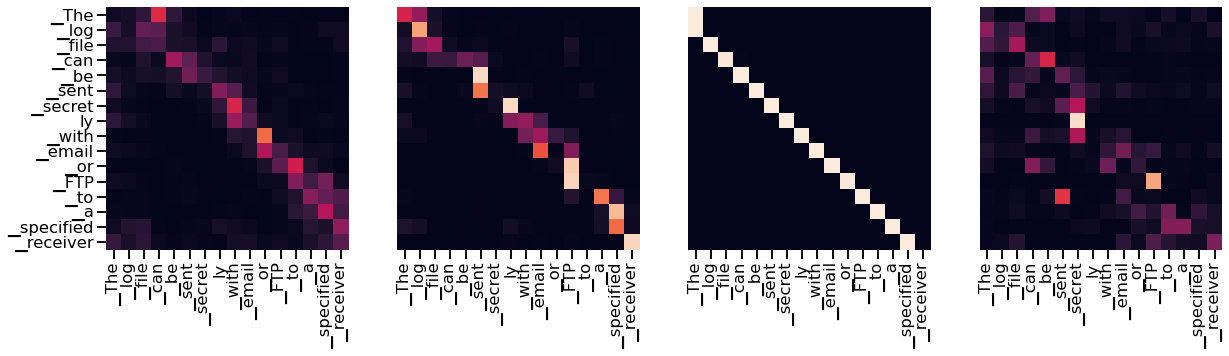

Encoder Layer 4


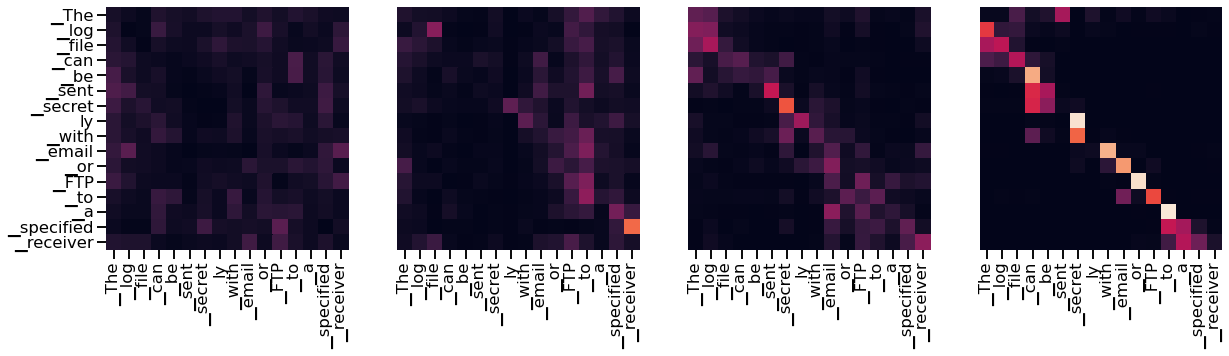

Encoder Layer 6


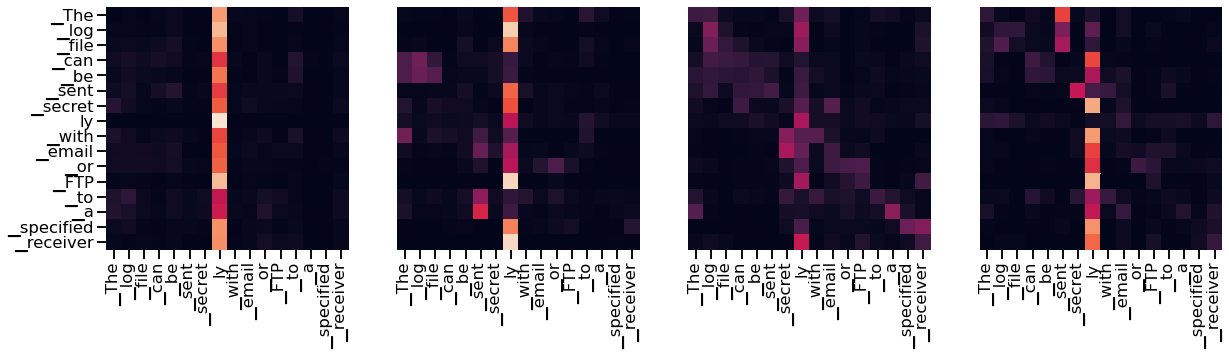

Decoder Self Layer 2


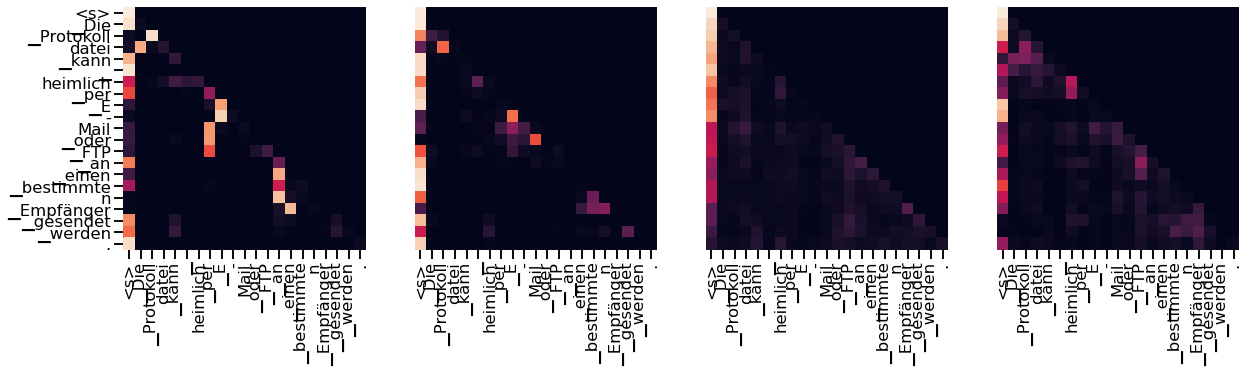

Decoder Src Layer 2


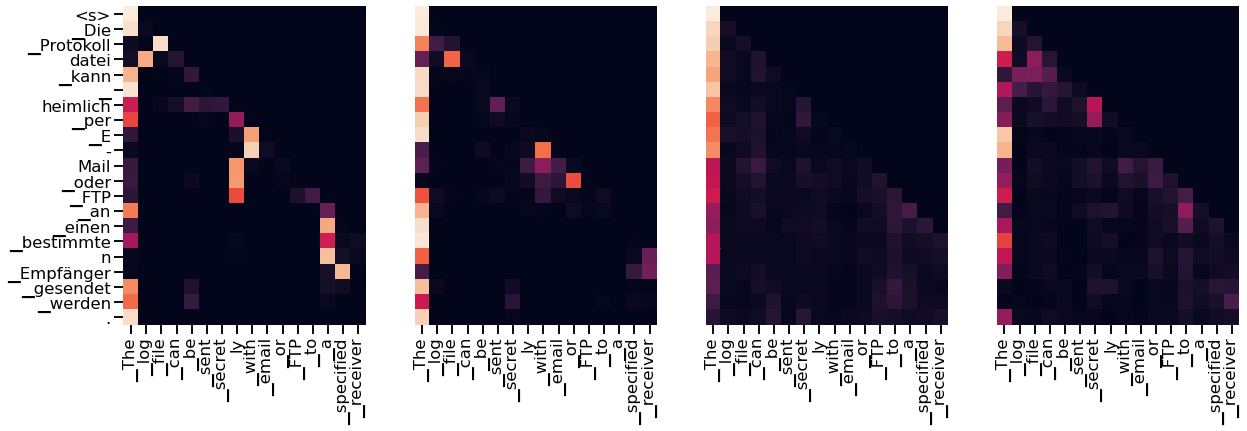

Decoder Self Layer 4


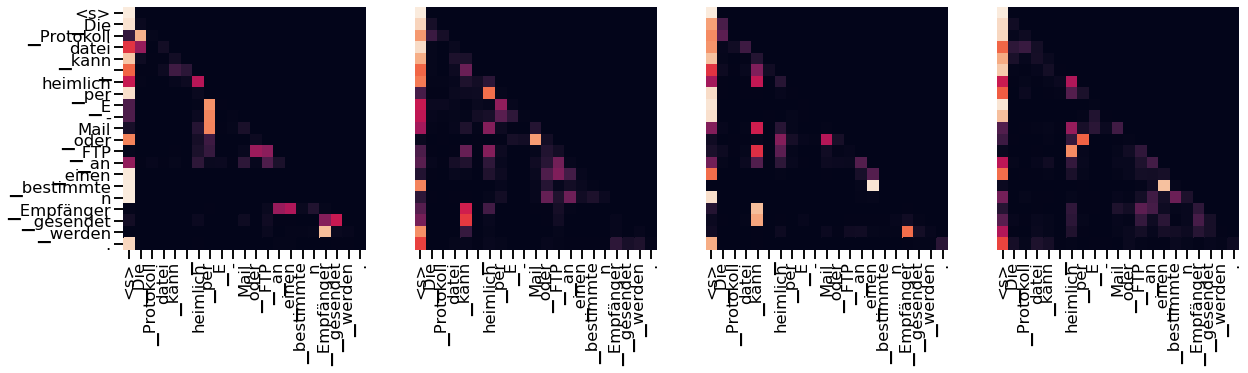

Decoder Src Layer 4


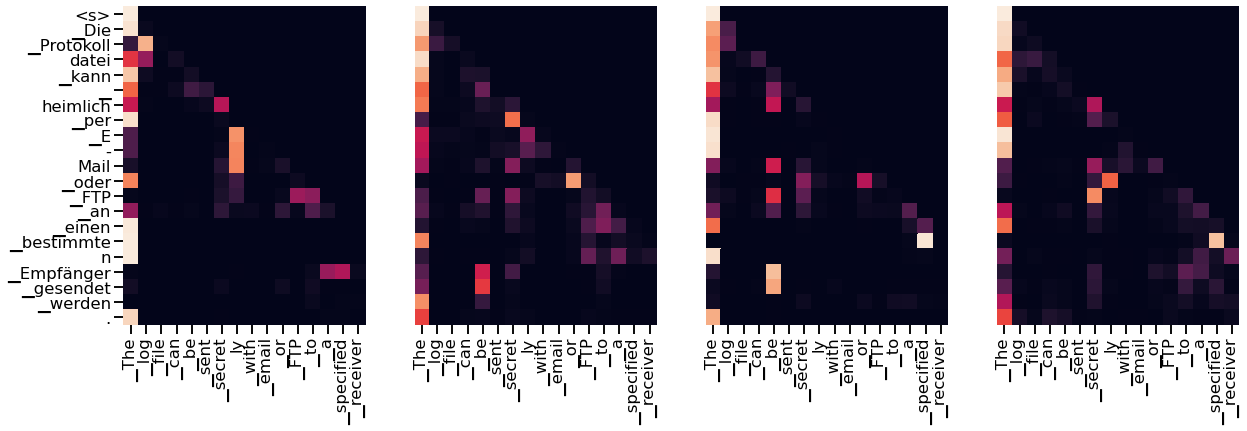

Decoder Self Layer 6


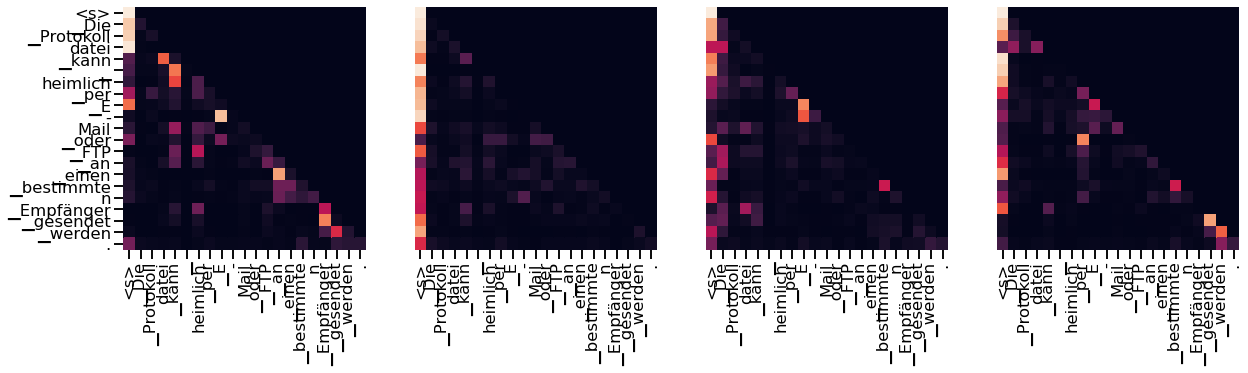

Decoder Src Layer 6


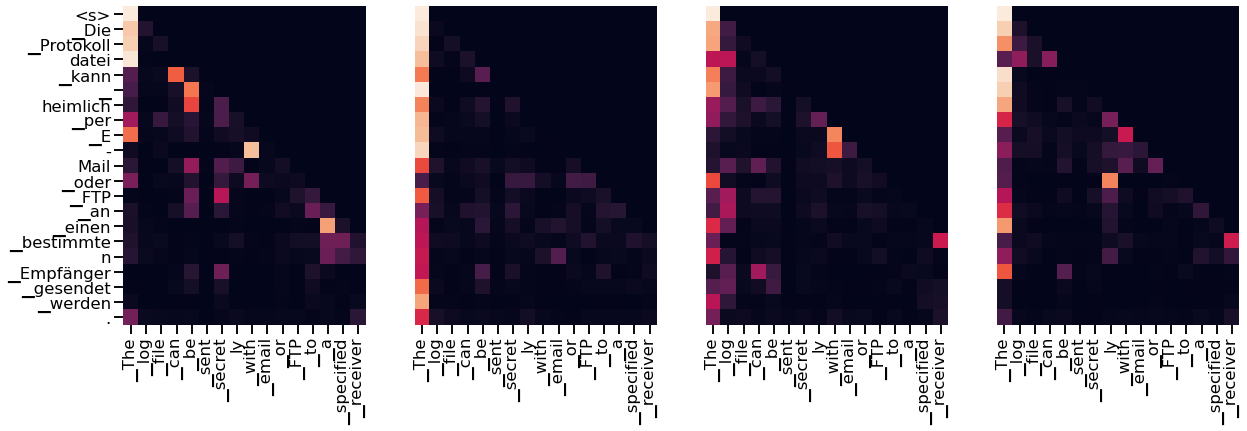

In [51]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()